# Import Modules

In [1]:
import re
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import WeightedRandomSampler
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from loguru import logger
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, PreTrainedTokenizer
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import wandb

tqdm.pandas()

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Prepare Dataset

In [2]:
dataset_path = "/home/mdafifal.mamun/notebooks/triagerX/notebook/data/openj9/openj9_processed.csv"

df = pd.read_csv(dataset_path)
df = df.rename(columns={"assignees": "owner", "issue_body": "description"})
df = df[df["owner"].notna()]
special_tokens = {
    "hex": "[HEX]",
    "timestamp": "[TIMESTAMP]",
    "float": "[FLOAT_VALUE]",
    "param": "[PARAM_VALUE]"
}

def clean_issue_description(text):
    cleaned_text = text.strip()
    cleaned_text = re.sub(r'0x[\da-fA-F]+', special_tokens["hex"], cleaned_text)
    cleaned_text = re.sub(r'\b[0-9a-fA-F]{16}\b', special_tokens["hex"], cleaned_text)
    cleaned_text = re.sub(r'\b\d{2}:\d{2}:\d{2}\.\d{3}\b', special_tokens["timestamp"], cleaned_text)
    cleaned_text = re.sub(r'\s*[-+]?\d*\.\d+([eE][-+]?\d+)?', special_tokens["float"], cleaned_text)
    cleaned_text = re.sub(r'=\s*-?\d+', f'= {special_tokens["param"]}', cleaned_text)
    
    return cleaned_text

def clean_data(df):
    df['text'] = df['text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', regex=True)
    df["text"] = df['text'].str.replace(" +", " ", regex=True)
    df["text"] = df["text"].apply(clean_issue_description)

    return df
    
def prepare_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df["text"] = df.progress_apply(
            lambda x: "Title: "
            + str(x["issue_title"])
            # + "\nComponent: "
            # + str(x["component"])
            # + "\nIssue Topic: "
            # + str(x["topic_label"])
            + "\nDescription: "
            + str(x["description"]),
            axis=1,
        )
    
    min_length = 15
    df = df[df["text"].str.len().gt(min_length)]

    # df["owner_id"] = pd.factorize(df["assignees"])[0]

    return df

df = prepare_dataframe(df)
df = clean_data(df)
df = df.sort_values(by="issue_number")

num_issues = len(df)

print(f"Total number of issues: {num_issues}")

100%|██████████| 4381/4381 [00:00<00:00, 115320.99it/s]


Total number of issues: 4381


In [3]:
vm_users = ['pshipton', 'keithc-ca', 'gacholio', 'tajila', 'babsingh', 'JasonFengJ9', 'fengxue-IS', 'hangshao0', 'theresa.t.mammarella', 'ChengJin01', 'singh264', 'thallium', 'ThanHenderson']
jvmti_users = ['gacholio', 'tajila', 'babsingh', 'fengxue-IS']
jclextensions_users = ['JasonFengJ9', 'pshipton', 'keithc-ca']
test_users = ['LongyuZhang', 'annaibm', 'sophiaxu0424', 'KapilPowar', 'llxia']
build_users = ['adambrousseau', 'mahdipub']
gc_users = ['dmitripivkine', 'amicic', 'kangyining', 'LinHu2016']

# Putting them in dictionaries
components = {
    'comp:vm': vm_users,
    'comp:jvmti': jvmti_users,
    'comp:jclextensions': jclextensions_users,
    'comp:test': test_users,
    'comp:build': build_users,
    'comp:gc': gc_users
}

expected_users = [user for user_list in components.values() for user in user_list]

In [4]:
df = df[df["owner"].isin(expected_users)]
print("Total issues after developer filtering:", len(df))

Total issues after developer filtering: 1992


In [5]:
df.owner.value_counts()

owner
JasonFengJ9      363
pshipton         317
keithc-ca        269
babsingh         251
hangshao0        108
gacholio         104
ChengJin01       100
fengxue-IS        99
llxia             97
tajila            81
LongyuZhang       41
LinHu2016         36
dmitripivkine     32
thallium          30
amicic            27
singh264          20
ThanHenderson     10
kangyining         6
sophiaxu0424       1
Name: count, dtype: int64

In [6]:
# Cross-Validation Fold Definition

num_cv = 10
sample_threshold = 10 # Threshold to filter developers
samples_per_block = len(df) // num_cv + 1
print(f"Samples per block: {samples_per_block}")

block = 9 
sliced_df = df[: samples_per_block * (block+1)]

Samples per block: 200


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Train and Validation preparation

# X_df = sliced_df[:samples_per_block*block]
# y_df = sliced_df[samples_per_block*block : samples_per_block * (block+2)]

X_df, y_df = train_test_split(df, test_size=0.2)

developers = X_df["owner"].value_counts()
filtered_developers = developers.index[developers >= sample_threshold]
X_df = X_df[X_df["owner"].isin(filtered_developers)]
# X_df["owner"] = X_df["owner"].apply(lambda x: x if x in filtered_developers else "minority")
# y_df["owner"] = y_df["owner"].apply(lambda x: x if x in filtered_developers else "minority")

train_owners = set(X_df["owner"])
test_owners = set(y_df["owner"])

unwanted = list(test_owners - train_owners)

y_df = y_df[~y_df["owner"].isin(unwanted)]

print(f"Training data: {len(X_df)}, Validation data: {len(y_df)}")
print(f"Number of developers: {len(X_df.owner.unique())}")

Training data: 1577, Validation data: 398
Number of developers: 16


<Axes: xlabel='owner'>

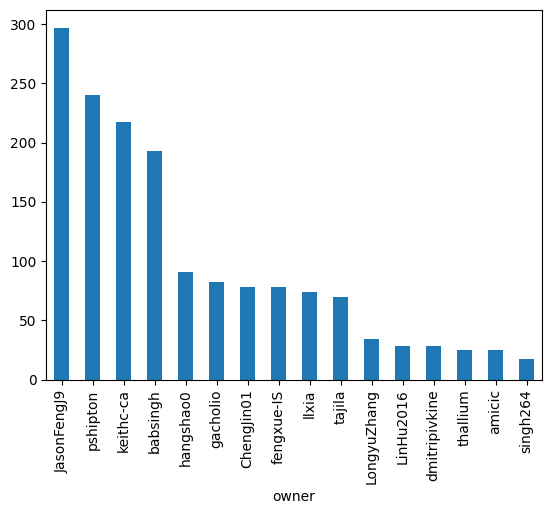

In [9]:
X_df.owner.value_counts().plot(kind="bar")

<Axes: xlabel='owner'>

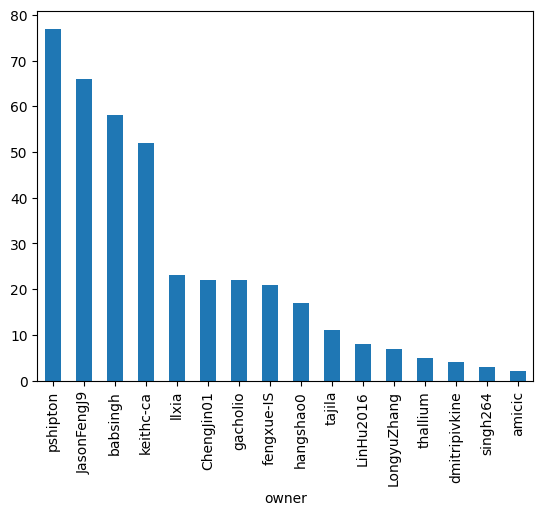

In [10]:
y_df.owner.value_counts().plot(kind="bar")

In [11]:
# Label encode developers

lbl2idx = {}

train_owners = sorted(train_owners)

for idx, dev in enumerate(train_owners):
    lbl2idx[dev] = idx

X_df["owner_id"] = X_df["owner"].apply(lambda owner: lbl2idx[owner])
y_df["owner_id"] = y_df["owner"].apply(lambda owner: lbl2idx[owner])

In [12]:
assert len(X_df.owner.unique()) == len(y_df.owner.unique())

In [13]:
lbl2idx

{'ChengJin01': 0,
 'JasonFengJ9': 1,
 'LinHu2016': 2,
 'LongyuZhang': 3,
 'amicic': 4,
 'babsingh': 5,
 'dmitripivkine': 6,
 'fengxue-IS': 7,
 'gacholio': 8,
 'hangshao0': 9,
 'keithc-ca': 10,
 'llxia': 11,
 'pshipton': 12,
 'singh264': 13,
 'tajila': 14,
 'thallium': 15}

<Axes: xlabel='owner_id'>

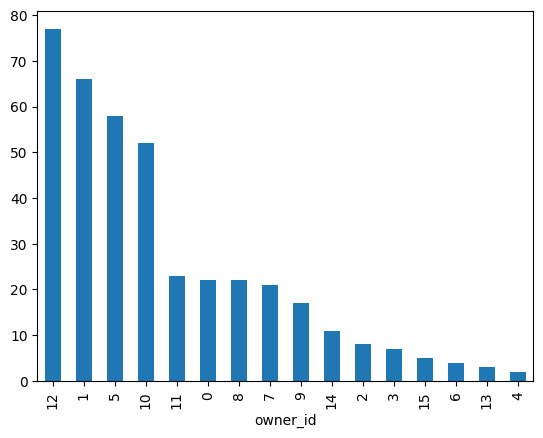

In [14]:
# Contribution plot

y_df.owner_id.value_counts().plot(kind="bar")

# Prepare PyTorch Dataset

In [15]:
class TriageDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        tokenizer: PreTrainedTokenizer,
        feature: str = "text",
        target: str = "owner_id",
    ):
        logger.debug("Generating torch dataset...")
        self.tokenizer = tokenizer
        self.labels = [label for label in df[target]]
        # self.embedding_model = SentenceTransformer("BAAI/bge-small-en")
        logger.debug("Tokenizing texts...")
        self.texts = [
            (row.text, self.tokenizer(
                row.text,
                padding="max_length",
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ))
            for _, row in df.iterrows()
        ]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


# Training Parameters

In [16]:
wandb.login()

wandb: Currently logged in as: afifaniks. Use `wandb login --relogin` to force relogin


True

In [17]:
from triagerx.model.lbt_p_deberta import LBTPDeberta
from triagerx.model.lbtp_bilstm import LBTPBiLSTM
from triagerx.loss.loss_functions import *

In [18]:
class_counts = np.bincount(X_df["owner_id"])
num_samples = sum(class_counts)
labels = X_df["owner_id"].to_list() # corresponding labels of samples

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


# Define hyperparameters
learning_rate = 1e-5
epochs = 40
batch_size = 10
unfrozen_layers=4
num_classes = len(X_df.owner_id.unique())

model = LBTPDeberta(
    output_size=num_classes, 
    unfrozen_layers=unfrozen_layers, 
    dropout=0.3, 
    base_model="microsoft/deberta-large"
)
# criterion = CombineLoss(weights=None)
criterion = CombinedLoss(weights=None)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
# scheduler = ReduceLROnPlateau(optimizer, "min", patience=2, factor=0.1, threshold=1e-10, verbose=True)

run_name = f"dev_ex_{model.__class__.__name__}_u{unfrozen_layers}_cv{block}_classes{num_classes}_{criterion.__class__.__name__}"
weights_save_location = f"/work/disa_lab/projects/triagerx/models/{run_name}.pt"
wandb.init(
    # Set the project where this run will be logged
    project="openj9_developers", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=run_name, 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "Deberta-LBT-P",
    "dataset": "openj9",
    "epochs": epochs,
})

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [19]:
tokenizer = model.tokenizer()

In [20]:
tokenizer.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [21]:
special_tokens_dict = {"additional_special_tokens": list(special_tokens.values())}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.base_model.resize_token_embeddings(len(tokenizer))

Embedding(50269, 1024)

In [22]:
# tokenizer.all_special_tokens
print(tokenizer.all_special_ids)

[1, 2, 3, 0, 50264, 50265, 50266, 50267, 50268]


In [23]:
X_df.to_csv("train_data.csv")
y_df.to_csv("test_data.csv")

In [24]:
# Prepare torch dataset from train and validation splits
train = TriageDataset(X_df, tokenizer)
val = TriageDataset(y_df, tokenizer)

2024-05-02 14:00:52.442 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-05-02 14:00:52.445 | DEBUG    | __main__:__init__:13 - Tokenizing texts...
2024-05-02 14:00:56.138 | DEBUG    | __main__:__init__:9 - Generating torch dataset...
2024-05-02 14:00:56.141 | DEBUG    | __main__:__init__:13 - Tokenizing texts...


In [25]:
train_dataloader = DataLoader(
    dataset=train,
    batch_size=batch_size,
    shuffle=False if sampler else True,
    sampler=sampler,
)
val_dataloader = DataLoader(val, batch_size=batch_size)

In [26]:
total_steps = len(train_dataloader) * epochs
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_loss = float("inf")

if torch.cuda.is_available():
    logger.debug(f"Selected compute device: {device}")
    model = model.cuda()
    criterion = criterion.cuda()

2024-05-02 14:00:57.116 | DEBUG    | __main__:<module>:5 - Selected compute device: cuda


In [28]:
def log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        train_data,
        validation_data,
        topk,
    ):
        log = f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                    | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                    | Val Loss: {total_loss_val / len(validation_data): .3f} \
                    | Val Accuracy: {total_acc_val / len(validation_data): .3f} \
                    | Top K: {topk} \
                    | Precision: {precision: .3f} \
                    | Recall: {recall: .3f} \
                    | F1-score: {f1_score: .3f}"
        
        wandb.log({
            "train_acc": total_acc_train / len(train_data), 
            "train_loss": total_loss_train / len(train_data),
            "val_acc": total_acc_val / len(validation_data),
            "val_loss": total_loss_val / len(validation_data),
            "top3_acc": topk,
            "precision": precision,
            "recall": recall,
            "f1-score": f1_score
        })

        logger.info(log)

# Training Loop

In [29]:
model = model.cuda()

In [30]:
for epoch_num in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader, desc="Training Steps"):
        # print(train_input)
        optimizer.zero_grad()

        train_label = train_label.to(device)
        mask = train_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = train_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = train_input[1]["token_type_ids"].squeeze(1).to(device)
        # print(tok_type.shape, input_id.shape, mask.shape)
        # print(repr.dtype, input_id.dtype, mask.dtype)

        output = model(input_id, mask, tok_type)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        output = torch.sum(torch.stack(output), 0)
        acc = (output.argmax(dim=1) == train_label).sum().item()
        
        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        scheduler.step()

    total_acc_val = 0
    total_loss_val = 0
    correct_top_k = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for val_input, val_label in tqdm(val_dataloader, desc="Validation Steps"):
            val_label = val_label.to(device)
            mask = val_input[1]["attention_mask"].squeeze(1).to(device)
            input_id = val_input[1]["input_ids"].squeeze(1).to(device)
            tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)

            output = model(input_id, mask, tok_type)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()

            output = torch.sum(torch.stack(output), 0)
            _, top_k_predictions = output.topk(3, 1, True, True)

            top_k_predictions = top_k_predictions.t()

            correct_top_k += (
                top_k_predictions.eq(
                    val_label.view(1, -1).expand_as(top_k_predictions)
                )
                .sum()
                .item()
            )

            acc = (output.argmax(dim=1) == val_label).sum().item()

            all_preds.append(output.argmax(dim=1).cpu().numpy())
            all_labels.append(val_label.cpu().numpy())

            total_acc_val += acc

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro"
    )

    topk = correct_top_k / len(y_df)

    log_step(
        epoch_num,
        total_acc_train,
        total_acc_val,
        total_loss_train,
        total_loss_val,
        precision,
        recall,
        f1_score,
        X_df,
        y_df,
        topk,
    )

    val_loss = total_loss_val / len(y_df)

    # if scheduler:
    #     scheduler.step()

    if val_loss < best_loss:
        logger.success("Found new best model. Saving weights...")
        torch.save(model.state_dict(), weights_save_location)
        best_loss = val_loss

Training Steps:   0%|          | 0/158 [00:00<?, ?it/s]

Validation Steps: 100%|██████████| 40/40 [00:15<00:00,  2.58it/s]
/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-05-02 14:03:38.574 | INFO     | __main__:log_step:34 - Epochs: 1 | Train Loss:  1.706                     | Train Accuracy:  0.073                     | Val Loss:  1.502                     | Val Accuracy:  0.038                     | Top K: 0.11055276381909548                     | Precision:  0.103                     | Recall:  0.048                     | F1-score:  0.031
2024-05-02 14:03:38.576 | SUCCESS  | __main__:<module>:99 - Found new best model. Saving weights...
Validation Steps: 100%|██████████| 40/40 [00:15<00:00,  2.59it/s]
2024-05-02 14:06:23.534 | INFO     | _

In [40]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


f1-score,▁▂▂▂▃▅▄▅▆▇▅▆▆▆▆▇▆█▇▇▆▆▆▇▇▇▇▇▇▇▇██▇▆▇██▇▇
precision,▁▂▁▁▂▄▃▃▅▅▃▄▅▅▅▆▅▇▇▆▄▆▄▇▆▆▆▅▆▇▆▇▇▆▅▅▇█▆▇
recall,▁▄▄▃▃▆▅▆▇█▆▆▆▆▆▇▆█▇▇▆▆▆▇▇██▇▇█▇██▇▆▇██▇▆
top3_acc,▁▂▂▃▄▅▅▅▆▆▇▆▆▆▇▆▇▇▇▇▇▇▇███▇█████▇███████
train_acc,▁▂▃▄▅▆▆▇▇▇▇▇▇███████████████████████████
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▃▃▅▄▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇▇██▇▇███▇▇
val_loss,█▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1-score,0.21352
precision,0.30577
recall,0.1975


# Evaluation

In [31]:
# Load best checkpoint
model.load_state_dict(torch.load(weights_save_location))

<All keys matched successfully>

In [32]:
loader = DataLoader(val, 30)

In [33]:
# Load embeddings for all train data
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')
all_embeddings = similarity_model.encode(X_df.issue_title.to_list(), batch_size=15)

/home/mdafifal.mamun/miniconda3/envs/trx/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [34]:
def get_top_k_similar_devs(issues, k=5, threshold=0.7):
    test_embed = similarity_model.encode(issues)
    cos = util.cos_sim(test_embed, all_embeddings)
    topk_values, topk_indices = torch.topk(cos, k=k)
    
    similarities = []
    
    for idx, sim_score in zip(topk_indices, topk_values):
        sim_threshold = sim_score >= threshold
        filtered_idx = idx[sim_threshold].numpy()
        similarities.append(X_df.iloc[filtered_idx]["owner_id"].unique().tolist())

    return similarities

In [38]:
total_acc_val = 0
total_loss_val = 0
correct_top_k = 0
correct_top_k_wo_sim = 0

all_preds = []
all_labels = []
device="cuda"

model = model.cuda()

with torch.no_grad():

    for val_input, val_label in loader:
        val_label = val_label.to(device)
        mask = val_input[1]["attention_mask"].squeeze(1).to(device)
        input_id = val_input[1]["input_ids"].squeeze(1).to(device)
        tok_type = val_input[1]["token_type_ids"].squeeze(1).to(device)

        output = model(input_id, mask, tok_type)

        output = torch.sum(torch.stack(output), 0)

        #wo similarity
        _, top_k_wo_sim = output.topk(3, 1, True, True)

        top_k_wo_sim = top_k_wo_sim.t()

        correct_top_k_wo_sim += (
            top_k_wo_sim.eq(
                val_label.view(1, -1).expand_as(top_k_wo_sim)
            )
            .sum()
            .item()
        )


        # with similarity
        # _, top_k_predictions = output.topk(3, 1, True, True)
        # similar_preds = get_top_k_similar_devs(val_input[0], threshold=0.65)

        # unique_preds = []

        # for top, sim in zip(top_k_predictions, similar_preds):
        #     # print(top, sim)
            
        #     copy_pred = top.cpu().numpy().tolist()
        #     top_preds = top.cpu().numpy().tolist()[:5]

        #     for s in sim:
        #         if s not in top_preds:
        #             top_preds.append(s)
            
        #     if len(top_preds) < 10:
        #         top_preds = top_preds + copy_pred[5:5 + 10 - len(top_preds)]
            
        #     unique_preds.append(top_preds)

        # unique_preds = torch.tensor(unique_preds).cuda()
        # top_k_predictions = unique_preds.t()

        # correct_top_k += (
        #     top_k_predictions.eq(
        #         val_label.view(1, -1).expand_as(top_k_predictions)
        #     )
        #     .sum()
        #     .item()
        # )

        # # break

        # acc = (output.argmax(dim=1) == val_label).sum().item()

        # all_preds.append(output.argmax(dim=1).cpu().numpy())
        # all_labels.append(val_label.cpu().numpy())

        total_acc_val += acc

In [39]:
print(f"Correct Prediction without Similarity: {correct_top_k_wo_sim}, {correct_top_k_wo_sim / len(y_df)}")
# print(f"Correct Prediction with Similarity: {correct_top_k}, {correct_top_k / len(y_df)}")

Correct Prediction without Similarity: 258, 0.6482412060301508


In [ ]:
all_preds_np = np.concatenate(all_preds)
all_labels_np = np.concatenate(all_labels)

# Result Analysis

In [ ]:
print(classification_report(all_labels_np, all_preds_np, target_names=labels))

ValueError: Number of classes, 15, does not match size of target_names, 1843. Try specifying the labels parameter

wandb: Network error (ReadTimeout), entering retry loop.


In [ ]:
idx2label = {
    row["owner_id"]: row["owner"]
    for _, row in y_df.iterrows()
}

labels = y_df.owner_id.to_list()
labels = sorted(set(labels))
labels = [f"{idx}: {idx2label[idx]}" for idx in labels]

In [ ]:
def get_topic_distribution(owner):
    print("Training topic distribution")
    print("=======================================")
    print(X_df[X_df.owner == owner].topic_label.value_counts())

    print("\n\nTesting topic distribution")
    print("=======================================")
    print(y_df[y_df.owner == owner].topic_label.value_counts())

In [ ]:
X_df.topic_label.value_counts()

Chrome Tab and Window Behavior Issues     947
Build failures                            840
Chrome stability issues                   487
Layout Testing Issues                     400
Chrome crash reports                      391
Security and SSL issues                   372
Input and keyboard issues                 370
Webpage rendering regression issues       357
Chrome sync issues                        354
Shill WiFi configuration                  337
iOS File Issues                           321
Data Enhancement                          298
Touch and Scroll Issues                   273
DevTools Crashes                          260
GPU rendering issues                      235
Memory Leaks in WebCore and Blink         220
Performance testing issues in Chromium    197
WebRTC audio/video issues                 184
Bookmark issues                           174
Performance Regression in Blink            13
Name: topic_label, dtype: int64

In [ ]:
get_topic_distribution("a...@chromium.org")

Training topic distribution
Chrome Tab and Window Behavior Issues     10
Webpage rendering regression issues        5
Memory Leaks in WebCore and Blink          4
Chrome stability issues                    4
DevTools Crashes                           3
Data Enhancement                           3
Input and keyboard issues                  3
Touch and Scroll Issues                    2
Bookmark issues                            1
Security and SSL issues                    1
Chrome sync issues                         1
Layout Testing Issues                      1
Build failures                             1
iOS File Issues                            1
Performance testing issues in Chromium     1
Name: topic_label, dtype: int64


Testing topic distribution
Chrome Tab and Window Behavior Issues     17
Webpage rendering regression issues        7
DevTools Crashes                           6
iOS File Issues                            6
Touch and Scroll Issues                    4
Input and k